In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('in_vivo_ephys_openephys')

from PostSorting.vr_sync_spatial_data \
    import calculate_instant_velocity, get_avg_speed_200ms, running_mean

from PostSorting.parameters import Parameters

from PostSorting.vr_FiringMaps_InTime \
import calculate_trial_in_time, calculate_trialtype_in_time, \
    convolve_spikes_in_time, convolve_position_in_time, convolve_speed_in_time, \
    generate_time_bins_for_speed, bin_spatial_array, convolve_binned_spikes

os.chdir('../')

In [32]:
pos_data = pd.read_pickle('position_data.pkl')
fr_data = pd.read_pickle('spatial_firing.pkl')

In [33]:
pos_data=pos_data.rename(columns={"speed_per200ms": "speed_target"})
pos_data

,x_position_cm,time_seconds,speed_target,trial_number,trial_type
0,183.00,0.000,0.000000,1,1
30,182.75,0.001,0.000000,1,1
60,182.75,0.002,0.000000,1,1
90,183.00,0.003,0.000000,1,1
120,182.75,0.004,0.000000,1,1
...,...,...,...,...,...
52304760,0.00,1743.492,0.006615,227,0
52304790,0.00,1743.493,0.000417,227,0
52304820,0.00,1743.494,0.000000,227,0
52304850,0.00,1743.495,0.000000,227,0


In [34]:
# trial_mask = pos_data['trial_number']>100
# plt.scatter(pos_data['x_position_cm'][trial_mask],pos_data['speed_per200ms'][trial_mask],alpha=0.005)
# plt.xlim([0,200])
fr_data

,session_id,cluster_id,tetrode,primary_channel,firing_times,firing_times_opto,recording_length_sampling_points,number_of_spikes,mean_firing_rate,recording_length_seconds,...,probe_trial_number,beaconed_firing_rate_map,non_beaconed_firing_rate_map,probe_firing_rate_map,beaconed_firing_rate_map_sem,non_beaconed_firing_rate_map_sem,probe_firing_rate_map_sem,ThetaPower,ThetaIndex,Boccara_theta_class
4,M3_D18_2020-11-21_14-29-49,5,1,4,"[645928.0, 1351321.0, 1943206.0, 2550762.0, 31...",[],52304896.0,103,0.059077,1743.4965,...,[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[],0.032807,0.021900,0
6,M3_D18_2020-11-21_14-29-49,7,2,2,"[12650.0, 27269.0, 61818.0, 65227.0, 66200.0, ...",[],52304896.0,6073,3.483230,1743.4965,...,[],"[6.5897858319604845, 2.394497010506767, 3.0358...","[0.0, 0.9415013808686923, 1.385553297616798, 4...",[],"[2.935760792727953, 0.6181390635442938, 0.8550...","[0.0, 0.7892821977047746, 0.44308596952152535,...",[],1.665959,0.017063,0
10,M3_D18_2020-11-21_14-29-49,12,2,3,"[3619.0, 7330.0, 9174.0, 18824.0, 24775.0, 384...",[],52304896.0,33320,19.111022,1743.4965,...,[],"[16.474464579901213, 21.115110001741492, 17.20...","[41.21586810922223, 24.949786593020345, 24.247...",[],"[2.809693205284718, 2.1556791146025662, 2.3567...","[20.560706134330456, 3.7002521237091432, 3.418...",[],5.997624,0.007225,0
11,M3_D18_2020-11-21_14-29-49,13,2,3,"[17817.0, 19191.0, 26186.0, 29574.0, 32090.0, ...",[],52304896.0,8461,4.852892,1743.4965,...,[],"[0.0, 0.2176815464097061, 0.6746348538853092, ...","[0.0, 0.0, 0.0, 0.580147357428788, 1.309328968...",[],"[0.0, 0.3467286155126386, 0.5553639433632767, ...","[0.0, 0.0, 0.0, 0.7905138339920547, 0.93757318...",[],1.324618,0.011598,0
12,M3_D18_2020-11-21_14-29-49,14,2,3,"[5127.0, 13860.0, 18690.0, 47291.0, 65617.0, 6...",[],52304896.0,8461,4.852892,1743.4965,...,[],"[3.2948929159802423, 3.2652231961455915, 3.373...","[0.0, 3.766005523474769, 7.620543136892388, 5....",[],"[1.190476190476196, 0.9372133024592326, 1.1997...","[0.0, 1.2559554108660225, 2.7679637328260442, ...",[],2.446640,0.103395,0
13,M3_D18_2020-11-21_14-29-49,16,2,4,"[427.0, 1738.0, 3136.0, 7668.0, 8312.0, 8525.0...",[],52304896.0,16455,9.437931,1743.4965,...,[],"[6.5897858319604845, 11.972485052533836, 9.782...","[10.303967027305557, 7.532011046949538, 4.8494...",[],"[2.4402233988851796, 1.703288092574061, 2.0901...","[4.293659403604641, 1.6602798292504333, 1.9241...",[],6.149038,0.159423,1
14,M3_D18_2020-11-21_14-29-49,17,2,4,"[378.0, 914.0, 2177.0, 7608.0, 8253.0, 9006.0,...",[],52304896.0,25136,14.417006,1743.4965,...,[],"[13.179571663920969, 13.060892784582366, 13.49...","[15.455950540958336, 12.710268641727346, 15.24...",[],"[2.637379779275643, 1.7220773451800553, 2.5002...","[28.531971210855286, 3.8097235519750132, 4.105...",[],8.074819,0.029236,0
17,M3_D18_2020-11-21_14-29-49,20,3,1,"[33911.0, 38883.0, 42242.0, 43517.0, 44025.0, ...",[],52304896.0,7553,4.332099,1743.4965,...,[],"[6.5897858319604845, 4.353630928194122, 1.6865...","[5.1519835136527785, 6.1197589756465, 6.234989...",[],"[4.350923849696349, 0.8407592190770009, 0.6179...","[3.6062026685899884, 1.5690016599415615, 1.814...",[],2.135871,0.075649,0
18,M3_D18_2020-11-21_14-29-49,22,3,1,"[2156.0, 5672.0, 6714.0, 7271.0, 8567.0, 9070....",[],52304896.0,34655,19.876725,1743.4965,...,[],"[26.359143327841938, 17.196842166366782, 21.25...","[15.455950540958336, 18.3592769269395, 22.1688...",[],"[6.120713655012394, 2.011289271124405, 3.00637...","[3.4000009242253264, 3.3407745221919516, 4.525...",[],10.699535,0.040383,0
19,M3_D18_2020-11-21_14-29-49,23,3,2,"[855.0, 999.0, 3091.0, 3170.0, 3377.0, 3586.0,...",[],52304896.0,74800,42.902294,1743.4965,...,[],"[46.12850082372339, 42.6655830963024, 36.76759...","[30.91190108191667, 38.13080592518204, 35.3316...",[],"[10.088455888318848, 3.3965091551265147, 3

In [35]:
pos_data

,x_position_cm,time_seconds,speed_target,trial_number,trial_type
0,183.00,0.000,0.000000,1,1
30,182.75,0.001,0.000000,1,1
60,182.75,0.002,0.000000,1,1
90,183.00,0.003,0.000000,1,1
120,182.75,0.004,0.000000,1,1
...,...,...,...,...,...
52304760,0.00,1743.492,0.006615,227,0
52304790,0.00,1743.493,0.000417,227,0
52304820,0.00,1743.494,0.000000,227,0
52304850,0.00,1743.495,0.000000,227,0


In [36]:
def calculate_instant_velocity(position_data, prm):
    print('Calculating velocity...')

    location = np.array(position_data['x_position_cm'], dtype=np.float32)

    for i in np.where(np.diff(location) < -10)[0]:
        diff = abs(np.diff(location[i:i+2]))
        location[i+1:] = np.add(location[i+1:], diff)

    sampling_points_per200ms = int(prm.get_sampling_rate()/5)
    end_of_loc_to_subtr = location[:-sampling_points_per200ms]# Rearrange arrays in a way that they just need to be subtracted from each other
    beginning_of_loc_to_subtr = location[:sampling_points_per200ms]# Rearrange arrays in a way that they just need to be subtracted from each other
    location_to_subtract_from = np.append(beginning_of_loc_to_subtr, end_of_loc_to_subtr)
    velocity = location - location_to_subtract_from

#     PostSorting.vr_make_plots.plot_raw_velocity(velocity, prm)

    position_data['velocity'] = np.array(velocity*5, dtype=np.float32)
    return position_data


prm = Parameters()
prm.set_sampling_rate(1000)
calculate_instant_velocity(pos_data,prm)
get_avg_speed_200ms(pos_data, prm)

Calculating velocity...
Calculating average speed...


,x_position_cm,time_seconds,speed_target,trial_number,trial_type,velocity,speed_per200ms
0,183.00,0.000,0.000000,1,1,0.0000,0.000000
30,182.75,0.001,0.000000,1,1,0.0000,0.000000
60,182.75,0.002,0.000000,1,1,0.0000,0.000000
90,183.00,0.003,0.000000,1,1,0.0000,0.000000
120,182.75,0.004,0.000000,1,1,0.0000,0.000000
...,...,...,...,...,...,...,...
52304760,0.00,1743.492,0.006615,227,0,1.8750,0.759375
52304790,0.00,1743.493,0.000417,227,0,0.3125,0.765625
52304820,0.00,1743.494,0.000000,227,0,1.2500,0.771875
52304850,0.00,1743.495,0.000000,227,0,1.2500,0.778125


(0.0, 200.0)

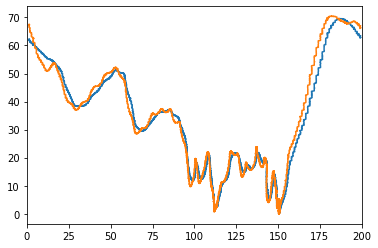

In [37]:
trial_mask = pos_data['trial_number']==100
plt.plot(pos_data['x_position_cm'][trial_mask],pos_data['speed_target'][trial_mask],alpha=1)
plt.plot(pos_data['x_position_cm'][trial_mask],pos_data['speed_per200ms'][trial_mask],alpha=1)
plt.xlim([0,200])

In [27]:
def convolve_speed_in_time(spike_data, cluster_index,raw_spatial_data, binned_trials, binned_trialtype):
    speed = np.array(raw_spatial_data["speed_per200ms"])
    number_of_bins = generate_time_bins_for_speed(speed)
    binned_speed = bin_spatial_array(speed, number_of_bins)
    convolved_speed = convolve_binned_spikes(binned_speed)

    sn=[]
    sn.append(convolved_speed)
    sn.append(binned_trials)
    sn.append(binned_trialtype)
    spike_data.at[cluster_index, 'speed_rate_in_time'] = list(sn)
    return spike_data, number_of_bins, binned_speed

def control_convolution_in_time(spike_data,raw_spatial_data):
    spike_data["spike_rate_in_time"] = ""
    spike_data["speed_rate_in_time"] = ""
    spike_data["position_rate_in_time"] = ""

    print('Spike data len',len(spike_data))
    for cluster in range(1): #len(spike_data)):
        cluster_index = spike_data.cluster_id.values[cluster] - 1
        print('Cluster idx',cluster_index)
        if cluster_index not in [22,27,37,39]:
            binned_trials = calculate_trial_in_time(raw_spatial_data)
            binned_trialtype = calculate_trialtype_in_time(raw_spatial_data)

            spike_data, number_of_bins, convolved_speed = convolve_speed_in_time(spike_data, cluster_index,raw_spatial_data, binned_trials, binned_trialtype)
            spike_data, binned_position = convolve_position_in_time(spike_data, cluster_index,raw_spatial_data, number_of_bins, binned_trials, binned_trialtype)
#             spike_data = convolve_spikes_in_time(spike_data, cluster_index,number_of_bins, convolved_speed, binned_position, binned_trials, binned_trialtype)
    return spike_data

spike_data = control_convolution_in_time(fr_data,pos_data)

Spike data len 23
Cluster idx 4
[      0    3000    6000    9000   12000   15000   18000   21000   24000
   27000   30000   33000   36000   39000   42000   45000   48000   51000
   54000   57000   60000   63000   66000   69000   72000   75000   78000
   81000   84000   87000   90000   93000   96000   99000  102000  105000
  108000  111000  114000  117000  120000  123000  126000  129000  132000
  135000  138000  141000  144000  147000  150000  153000  156000  159000
  162000  165000  168000  171000  174000  177000  180000  183000  186000
  189000  192000  195000  198000  201000  204000  207000  210000  213000
  216000  219000  222000  225000  228000  231000  234000  237000  240000
  243000  246000  249000  252000  255000  258000  261000  264000  267000
  270000  273000  276000  279000  282000  285000  288000  291000  294000
  297000  300000  303000  306000  309000  312000  315000  318000  321000
  324000  327000  330000  333000  336000  339000  342000  345000  348000
  351000  354000  3

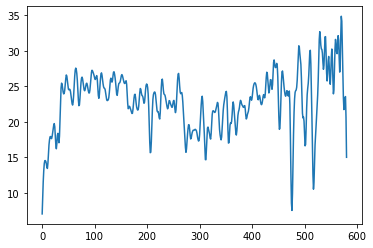

In [26]:
plt.plot(np.array(spike_data['speed_rate_in_time'][4][0]))

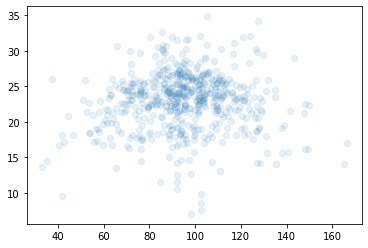

In [10]:
cid=6
plt.scatter(np.array(spike_data['position_rate_in_time'][cid][0]),
            np.array(spike_data['speed_rate_in_time'][cid][0]),alpha=0.1)

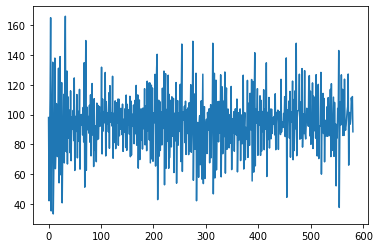

In [11]:
plt.plot(np.array(spike_data['position_rate_in_time'][4][0]))